In [19]:
import pandas as pd
import matplotlib.pyplot as plt

### Data

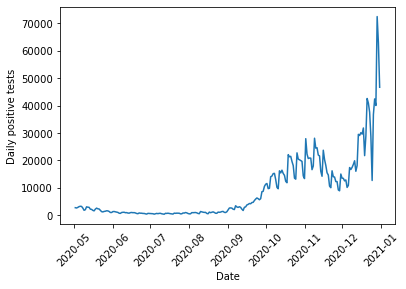

In [24]:
def get_data(query_type, start, end):
    "Queries UK Covid Data API for a particular type of data and returns data queried during a specific time frame"
    url = 'https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22query_type%22:%22query_type%22%7D&format=csv'
    new_url = url.replace("query_type", query_type)
    df = pd.read_csv(new_url)
    df["date"] = pd.to_datetime(df["date"])
    query_string = 'areaName == "England" & date >= "{}" & date <= "{}"'.format(start, end)
    return df.query(query_string)

cases_str = "newCasesBySpecimenDate"
cases = get_data(cases_str, "2020-05-02", "2020-12-31")

plt.plot(cases["date"], cases[cases_str])
plt.xlabel("Date")
plt.ylabel("Daily positive tests")
plt.xticks(rotation=45);

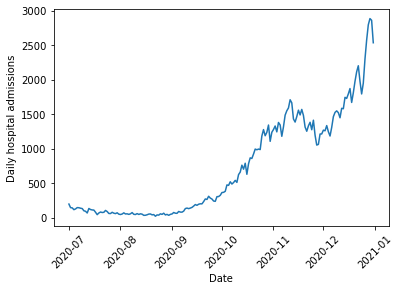

In [25]:
admissions_str = "newAdmissions"
admissions = get_data(admissions_str, "2020-07-01", "2020-12-31")
plt.plot(admissions["date"], admissions[admissions_str])
plt.xlabel("Date")
plt.ylabel("Daily hospital admissions")
plt.xticks(rotation=45);

### Model

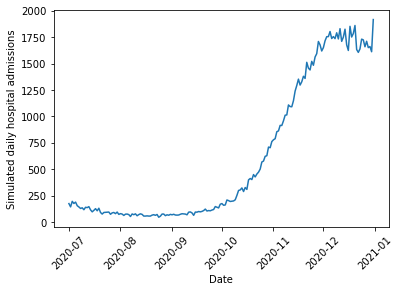

In [26]:
import numpy as np
from scipy.stats import binom, nbinom, multinomial

def reverse_df_data(df, column):
    return np.array(df[column], dtype=np.int64)[::-1]

def simulate_hospital_admissions(cases, psi, k, p):
    "Run a random forward simulation of the hospitalizations given cases and the model parameters"
    
    daily_hospital_admissions = binom.rvs(n=cases, p=np.broadcast_to(psi, (len(cases),)), size=(len(cases),))
    
    window = 60
    dates = np.arange(0, window, 1, dtype=np.int64)
    
    admission_probs = nbinom.pmf(dates, loc=k, n=k, p=p)
    
    # Run a few checks on admission_probs to avoid issues with multinomial sampling
    
    if np.sum(admission_probs) > 1.:
        admission_probs = admission_probs/(1.+1.e-10)
    if np.any(np.isnan(admission_probs)):
        return np.zeros(len(cases)-window, dtype=np.int64)
    
    admissions = np.zeros(len(cases)+window)
    for i in range(len(daily_hospital_admissions)):
        admit_samples = multinomial.rvs(n=daily_hospital_admissions[i], p=admission_probs, size=1)[0]
        admissions[i:i+window] += admit_samples
    
    return admissions[window:-window]

case_array = reverse_df_data(cases, cases_str)
admissions_array = simulate_hospital_admissions(case_array, 0.1, 4, 0.1)

plt.plot(admissions["date"][::-1], admissions_array)
plt.xlabel("Date")
plt.ylabel("Simulated daily hospital admissions")
plt.xticks(rotation=45);

In [29]:
%pip install pymc3
from functools import partial
import pymc3

def fit_model(simulation, cases, hospitalization, epsilon):
    
    simulate_hospital = partial(simulation, cases=cases)

    with pymc3.Model():
        psi = pymc3.Beta("psi", alpha=0.5, beta=2.)
        p = pymc3.Beta("p", alpha=1., beta=1.)
        k = pymc3.DiscreteUniform("k", lower=1, upper=20)
    
        sim_admissions = pymc3.Simulator("admissions", simulate_hospital,
                                         params=(psi, k, p), epsilon=epsilon,
                                         observed=hospitalization)

        trace = pymc3.sample_smc(kernel="ABC", chains=1)

    return trace

obs_array = reverse_df_data(admissions, admissions_str)
epsilon = 500.

trace = fit_model(simulate_hospital_admissions, case_array, obs_array, epsilon)

     |████████████████████████████████| 869 kB 492 kB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 497 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 446 kB/s eta 0:00:01
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
     |████████████████████████████████| 845 kB 482 kB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 431 kB/s eta 0:00:01
     |████████████████████████████████| 220 kB 260 kB/s eta 0:00:01
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529946 sha256=eb3671b88fe6366fcbee55938942bf49aca473a6f5c1415b88986fe4611a8458
  Stored in directory: /home/majid/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.1.1
    Uninstalling cachetools-4.1.1:
      Successfully uninstalled cachetools-4.1.1
Note: you may need to restart the kernel to use updated packa

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.171
Stage:   4 Beta: 0.357
Stage:   5 Beta: 0.601
Stage:   6 Beta: 1.000


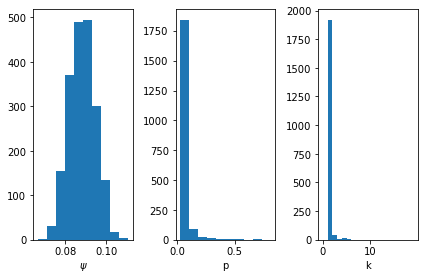

In [30]:
plt.subplot(131)
plt.hist(trace["psi"], bins=10)
plt.xlabel("$\psi$")
plt.subplot(132)
plt.hist(trace["p"], bins=10)
plt.xlabel("p")
plt.subplot(133)
plt.hist(trace["k"], bins=list(range(0, 20)));
plt.xlabel("k")
plt.tight_layout()

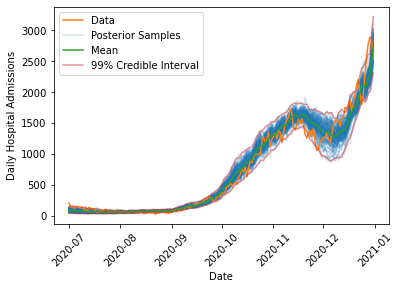

In [31]:
def draw_posterior_samples(cases, trace):
    "Draw samples from the simulation using the SMC samples"

    samples = []

    for s in trace:
        samples.append(simulate_hospital_admissions(cases, s["psi"], s["k"], s["p"]))

    return np.array(samples)

def compute_posterior_statistics(samples):
    "Compute mean and credible intervals from posterior samples"
    
    mean = np.mean(samples, axis=0)
    quantile_005 = np.quantile(samples, 0.005, axis=0)
    quantile_995 = np.quantile(samples, 0.995, axis=0)
    
    return mean, quantile_005, quantile_995

def plot_data_with_samples(cases, admissions, trace):
    
    samples = draw_posterior_samples(cases, trace)
    
    mean, quantile_005, quantile_995 = compute_posterior_statistics(samples)

    plt.plot(admissions["date"][::-1], samples.T[:,:100], color="C0", alpha=0.2)
    plt.plot(admissions["date"], admissions[admissions_str], color="C1", label="Data")
    plt.xlabel("Date")
    plt.ylabel("Daily Hospital Admissions")
    plt.plot([], [], color='C0', alpha=0.2, label='Posterior Samples')
    plt.plot(admissions["date"][::-1], mean, color="C2", label="Mean")
    plt.plot(admissions["date"][::-1], quantile_005, color="C3", alpha=0.5)
    plt.plot(admissions["date"][::-1], quantile_995, color="C3", alpha=0.5, label="99% Credible Interval")
    plt.legend()
    plt.xticks(rotation=45)
    
plot_data_with_samples(case_array, admissions, trace)
